C:\Users\Premkumar.Nagendran\AppData\Local\Temp\ipykernel_20112\4000260076.py:14: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(
C:\Users\Premkumar.Nagendran\AppData\Local\Temp\ipykernel_20112\4000260076.py:14: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(
C:\Users\Premkumar.Nagendran\AppData\Local\Temp\ipykernel_20112\4000260076.py:14: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(


Data shape: (2075259, 8)
             DateTime  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00                4.216                  0.418   234.84   
1 2006-12-16 17:25:00                5.360                  0.436   233.63   
2 2006-12-16 17:26:00                5.374                  0.498   233.29   
3 2006-12-16 17:27:00                5.388                  0.502   233.74   
4 2006-12-16 17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data c

C:\Users\Premkumar.Nagendran\AppData\Local\Temp\ipykernel_20112\4000260076.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_val, inplace=True)


Voltage skewness: -0.33 -- Filling missing values with median: 241.01
Global_intensity skewness: 1.85 -- Filling missing values with median: 2.6
Sub_metering_1 skewness: 5.94 -- Filling missing values with median: 0.0
Sub_metering_2 skewness: 7.09 -- Filling missing values with median: 0.0
Sub_metering_3 skewness: 0.72 -- Filling missing values with median: 1.0


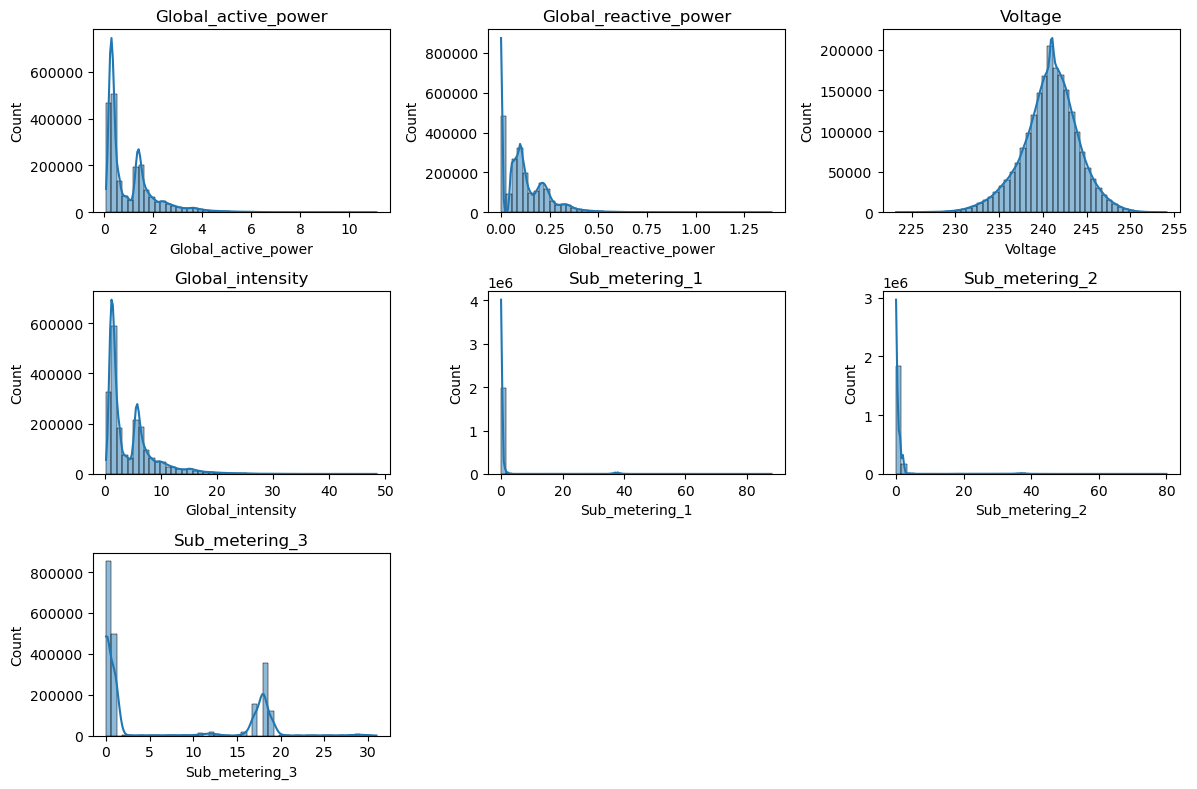

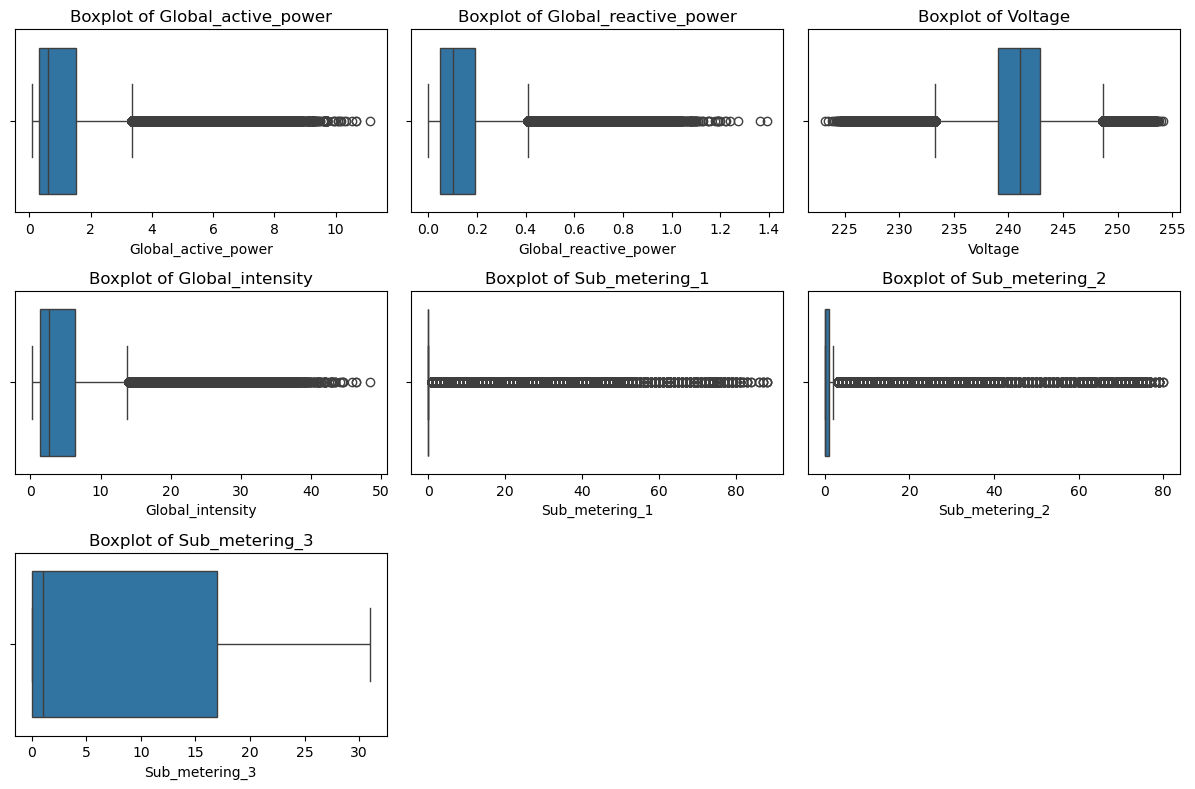

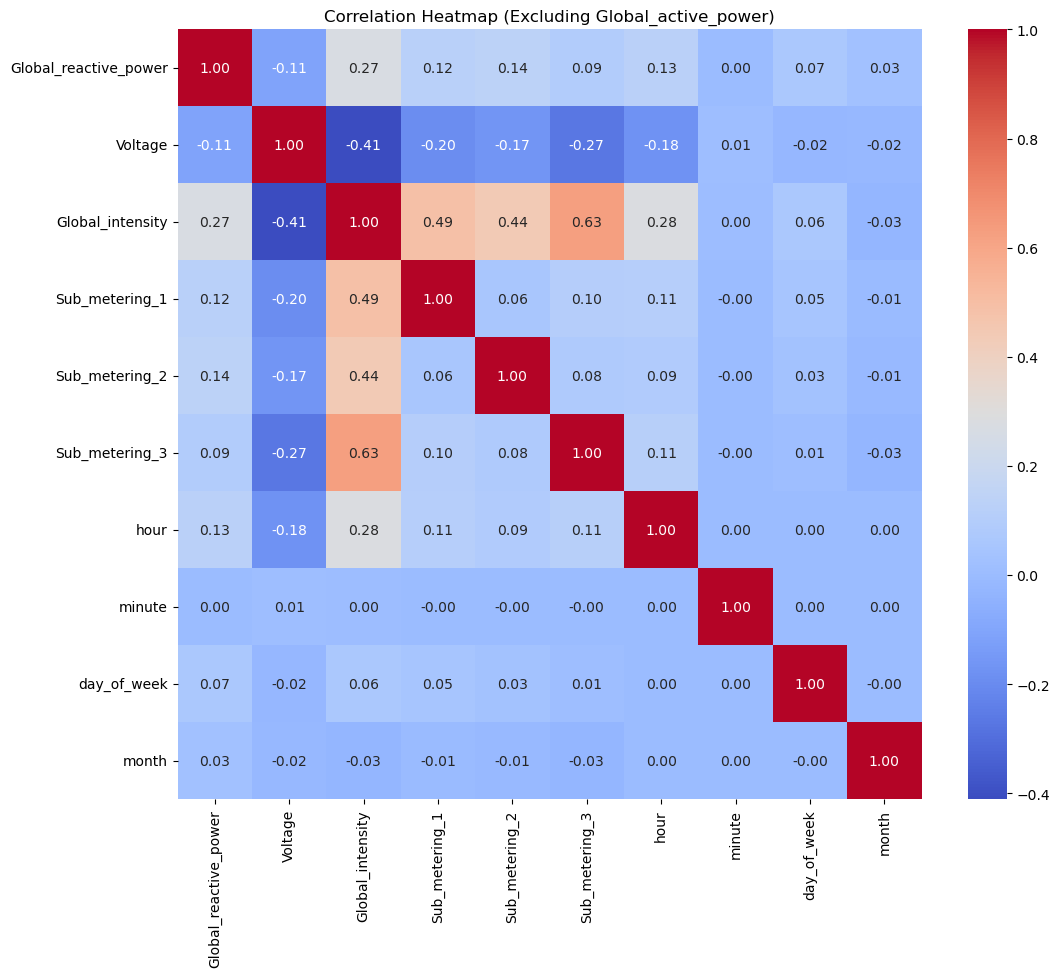

Columns to drop: set()


In [2]:
# %% Cell 1: Data Understanding and Exploration
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set your data folder and file path
data_folder = r'C:\Users\Premkumar.Nagendran\OneDrive - Agilisium Consulting India Private Limited\Mini Projects\PowerPulse Household Energy Usage Forecast\data'
data_file = 'household_power_consumption.txt'
data_path = os.path.join(data_folder, data_file)

# Load the data (semicolon separator; '?' indicates missing values)
data = pd.read_csv(
    data_path,
    sep=';',
    parse_dates={'DateTime': ['Date', 'Time']},
    infer_datetime_format=True,
    low_memory=False,
    na_values=['?']
)

# Basic information and summary
print("Data shape:", data.shape)
print(data.head())
print(data.info())
print(data.describe())

# Convert numeric columns and fill missing values with median
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    median_val = data[col].median()
    print(f"{col} skewness: {data[col].skew():.2f} -- Filling missing values with median: {median_val}")
    data[col].fillna(median_val, inplace=True)

# Create additional time-based features for exploration
data['year'] = data['DateTime'].dt.year
data['month'] = data['DateTime'].dt.month
data['day'] = data['DateTime'].dt.day
data['hour'] = data['DateTime'].dt.hour
data['minute'] = data['DateTime'].dt.minute
data['day_of_week'] = data['DateTime'].dt.dayofweek  # Monday=0, Sunday=6

# ---- Univariate Analysis ----
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(data[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# ---- Outlier Detection using Boxplots ----
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# ---- Bivariate Analysis: Correlation Heatmap (excluding target) ----
# Exclude 'Global_active_power' from the feature set for correlation
feature_cols_for_corr = [col for col in numeric_cols if col != 'Global_active_power']
additional_time_features = ['hour', 'minute', 'day_of_week', 'month']
corr_matrix = data[feature_cols_for_corr + additional_time_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap (Excluding Global_active_power)")
plt.show()

# ---- Remove Highly Correlated Features ----
threshold = 0.75
cols_to_drop = set()
corr_matrix_no_na = corr_matrix.fillna(0)
for i in range(len(corr_matrix_no_na.columns)):
    for j in range(i):
        if abs(corr_matrix_no_na.iloc[i, j]) > threshold:
            colname = corr_matrix_no_na.columns[i]
            print(f"High correlation: {corr_matrix_no_na.columns[j]} & {colname} (corr = {corr_matrix_no_na.iloc[i,j]:.2f}). Dropping {colname}.")
            cols_to_drop.add(colname)
print("Columns to drop:", cols_to_drop)


In [3]:
# %% Cell 2: Additional Preprocessing – Daily Averages and Peak Hours
# Extract date for aggregation (without time)
data['Date'] = data['DateTime'].dt.date

# Daily Average: Group by Date and calculate mean of Global_active_power
daily_avg = data.groupby('Date')['Global_active_power'].mean().reset_index()
daily_avg.rename(columns={'Global_active_power': 'Daily_Avg_Global_active_power'}, inplace=True)
print("Daily Average (first 5 rows):")
print(daily_avg.head())

# Save daily averages as a CSV file
daily_avg_csv_path = os.path.join(data_folder, 'daily_average_global_active_power.csv')
daily_avg.to_csv(daily_avg_csv_path, index=False)
print("Daily average data saved to:", daily_avg_csv_path)

# Peak Hours: Group by hour and calculate mean Global_active_power
hourly_avg = data.groupby('hour')['Global_active_power'].mean().reset_index()
hourly_avg.rename(columns={'Global_active_power': 'Hourly_Avg_Global_active_power'}, inplace=True)
print("Peak Hours (Top 5 by average power):")
print(hourly_avg.sort_values(by='Hourly_Avg_Global_active_power', ascending=False).head())


Daily Average (first 5 rows):
         Date  Daily_Avg_Global_active_power
0  2006-12-16                       3.053475
1  2006-12-17                       2.354486
2  2006-12-18                       1.530435
3  2006-12-19                       1.157079
4  2006-12-20                       1.545658
Daily average data saved to: C:\Users\Premkumar.Nagendran\OneDrive - Agilisium Consulting India Private Limited\Mini Projects\PowerPulse Household Energy Usage Forecast\data\daily_average_global_active_power.csv
Peak Hours (Top 5 by average power):
    hour  Hourly_Avg_Global_active_power
20    20                        1.885497
21    21                        1.863917
19    19                        1.720547
7      7                        1.490001
8      8                        1.449442


In [4]:
# %% Cell 3: Data Preprocessing for Modeling and Feature Selection
from sklearn.preprocessing import StandardScaler

# Define initial feature list (without target)
initial_feature_cols = ['hour', 'minute', 'day_of_week', 'month',
                        'Global_reactive_power', 'Voltage', 'Global_intensity',
                        'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Remove features that are highly correlated (if any)
feature_cols = [col for col in initial_feature_cols if col not in cols_to_drop]
print("Features used for modeling:", feature_cols)

# Define X (features) and y (target)
X = data[feature_cols]
y = data['Global_active_power']

# Scale features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Features used for modeling: ['hour', 'minute', 'day_of_week', 'month', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [ ]:
# %% Cell 4: Model Selection, Training, and Evaluation
import time
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split data chronologically (80% train, 20% test)
split_index = int(0.8 * len(data))
X_train_scaled, X_test_scaled = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Training set:", X_train_scaled.shape, y_train.shape)
print("Testing set:", X_test_scaled.shape, y_test.shape)

# --- Define Models and Hyperparameter Grids ---
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Dictionary to hold model configurations
models_config = {}

# Linear Regression (no hyperparameters to tune)
models_config['Linear Regression'] = {
    'model': LinearRegression(),
    'params': {}
}

# Random Forest Regression
models_config['Random Forest'] = {
    'model': RandomForestRegressor(random_state=42),
    'params': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
}

# Gradient Boosting Regression
models_config['Gradient Boosting'] = {
    'model': GradientBoostingRegressor(random_state=42),
    'params': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05], 'max_depth': [3, 5]}
}

# Neural Network (MLP Regressor)
models_config['Neural Network'] = {
    'model': MLPRegressor(random_state=42, max_iter=500),
    'params': {'hidden_layer_sizes': [(50,), (100,), (50,50)], 'alpha': [0.0001, 0.001]}
}

# AdaBoost Regression (New model)
models_config['AdaBoost'] = {
    'model': AdaBoostRegressor(random_state=42),
    'params': {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.5, 1.0]}
}

# Train models, tune hyperparameters (if applicable), and evaluate
models = {}
results = {}

for name, config in models_config.items():
    print(f"\nTraining {name}...")
    model = config['model']
    params = config['params']
    
    if params:  # Perform GridSearchCV if hyperparameters are provided
        grid = GridSearchCV(model, params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        start = time.time()
        grid.fit(X_train_scaled, y_train)
        print(f"{name} training time: {time.time() - start:.2f} seconds")
        best_model = grid.best_estimator_
        print(f"Best parameters for {name}:", grid.best_params_)
    else:
        # For Linear Regression (or models without parameters)
        start = time.time()
        model.fit(X_train_scaled, y_train)
        print(f"{name} training time: {time.time() - start:.2f} seconds")
        best_model = model

    models[name] = best_model
    y_pred = best_model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = rmse
    print(f"{name} -- RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

# Identify the best model based on RMSE
best_model_name = min(results, key=results.get)
print("\nBest model based on RMSE:", best_model_name)
best_model = models[best_model_name]


In [ ]:
# %% Cell 5: Save the Best Model and Make Predictions
import pickle

# Save only the best model to a pickle file
best_model_pickle_path = os.path.join(data_folder, 'best_model.pkl')
with open(best_model_pickle_path, 'wb') as f:
    pickle.dump(best_model, f)
print("Best model saved to:", best_model_pickle_path)

# To simulate a prediction step using the saved model:
with open(best_model_pickle_path, 'rb') as f:
    loaded_model = pickle.load(f)

# Predict on the test set using the loaded best model
y_pred_best = loaded_model.predict(X_test_scaled)

# Visualize Actual vs Predicted values for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.xlabel('Actual Global Active Power')
plt.ylabel('Predicted Global Active Power')
plt.title(f'{best_model_name}: Actual vs Predicted Global Active Power')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

# Optionally, print final performance metrics
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
final_mae = mean_absolute_error(y_test, y_pred_best)
final_r2 = r2_score(y_test, y_pred_best)
print(f"Final Performance of {best_model_name} -- RMSE: {final_rmse:.3f}, MAE: {final_mae:.3f}, R²: {final_r2:.3f}")
